****Unsupervised ML Example: Cyclohexane****

This notebook serves as an example of how to analyze a simulation trajectory using unsupervised techniques. Here, specifically, we'll be analyzing a simulation of cyclohexane conformations, simulated using quantum-espresso.

Before running this notebook, you will need to install:
    
- [ase](https://wiki.fysik.dtu.dk/ase/index.html)
- [scikit-learn](https://scikit-learn.org/)
- [scikit-cosmo](https://github.com/cosmo-epfl/scikit-cosmo)
- [librascal](https://github.com/cosmo-epfl/librascal)
- [openTSNE](https://opentsne.readthedocs.io/en/latest/)

in addition to standard packages [numpy](https://numpy.org/), [tqdm](https://github.com/tqdm/tqdm), and [matplotlib](https://matplotlib.org/).

In [1]:
import os
import sys
from functools import partial

import ase
import numpy as np
from ase.io import read, write
from matplotlib import pyplot as plt
from openTSNE import TSNE
from rascal.representations import SphericalInvariants as SOAP
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import normalize
from tqdm.auto import tqdm

from utils import set_mpl_fonts

set_mpl_fonts()

## Preparing the Data

### Read Data


In [2]:
# read in the frames from each MD simulation
traj = []
names = ['chair', 'twist-boat', 'boat', 'half-chair', 'planar']
rgb_colors = [(0.13333333333333333, 0.47058823529411764, 0.7098039215686275),
                (0.4588235294117647, 0.7568627450980392, 0.34901960784313724),
                (0.803921568627451, 0.6078431372549019, 0.16862745098039217),
                (0.803921568627451, 0.13725490196078433, 0.15294117647058825),
                (0.4392156862745098, 0.2784313725490196, 0.611764705882353),]

ranges = np.zeros((len(names), 2), dtype=int)
conf_idx = np.zeros(len(names), dtype=int)

for i, n in enumerate(names):
    frames = read(f'./cyclohexane_data/MD/{n}.xyz', '::')

    for frame in frames:
        # wrap each frame in its box
        frame.wrap(eps=1E-10)

        # mask each frame so that descriptors are only centered on carbon (#6) atoms
        mask = np.zeros(len(frame))
        mask[np.where(frame.numbers == 6)[0]] = 1
        frame.arrays['center_atoms_mask'] = mask

    ranges[i] = (len(traj), len(traj) + len(frames))
    conf_idx[i] = len(traj)
    traj = [*traj, *frames]

In [3]:
# energies of the simulation frames
energy = np.array([a.info['energy_eV'] for a in traj])

# energies of the known conformers
c_energy = np.array([traj[c].info['energy_eV'] for c in conf_idx])

# extrema for the energies
max_e = max(energy)
min_e = min(energy)

Here we can confirm what our analysis will tell us: the simulation starts in the planar conformation, transitions to the metastable half-chair configuration, then moves through the boat configuration until it ultimately reaches the chair conformation.

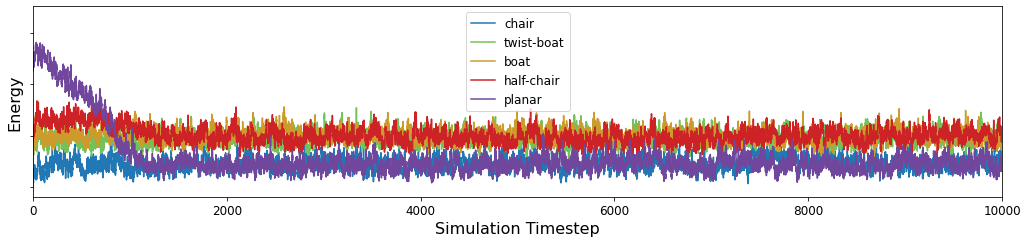

In [4]:
fig, ax = plt.subplots(1, figsize=(3*4.8528, 3*1.2219))

for n, c, r, rgb in zip(names, c_energy, ranges, rgb_colors):
    ax.plot(range(0, r[1] - r[0]),
            energy[r[0]:r[1]] - min_e,
            label=n,
            c=rgb,
            zorder=-1)
    
ax.legend()
ax.set_xlabel("Simulation Timestep")
ax.set_ylabel("Energy")

ax.set_xlim([0, len(energy)//5])
ax.set_ylim([-0.1, 1.25 * (max_e - min_e)])
ax.set_yticklabels([])

plt.tight_layout()
plt.savefig('figures/Figure5/energy.png')
plt.show()

### Create SOAP descriptors 
We create soap descriptor with the help of `rascal` library as below. The main important parameters are 

- `interaction_cutoff=3.5`: we are considering 3.5A radius of sphere for describing each atom environments. For cyclohexane, this includes the whole ring, which is necessary to differentiate conformers
- `max_radial=4`: expand over 4 radial GTO bases (6 GTO bases were used for figures in the text)
- `max_angular=4`: expand over the first 4 spherical harmonics (9 spherical harmonics were used for figures in the text)
- `gaussian_sigma_constant=0.3`: assume each atom has a gaussian of size sigma=0.3 imposed on its lattice site

Because we are focused on structure-level analysis, we average the descriptors for each configuration across all environmental centers and normalize to remove the feature means (we do the normalization explicitly in order to normalize both set of vectors by the same factors).

For more information on SOAP vectors and their implementation in librascal, we point the readers to [(Bartòk 2012)](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.87.184115), [(Musil 2017)](https://aip.scitation.org/doi/full/10.1063/1.5090481), [(Musil 2021)](https://aip.scitation.org/doi/full/10.1063/5.0044689), and [(Goscinski 2021)](https://aip.scitation.org/doi/full/10.1063/5.0057229).

In [5]:
hypers = {
    "interaction_cutoff": 3.5,
    "max_radial": 6,
    "max_angular": 9,
    "gaussian_sigma_constant": 0.3,
    "gaussian_sigma_type": "Constant",
    "cutoff_smooth_width": 0.8,
    "radial_basis": "GTO",
    "global_species": [1, 6],
    "expansion_by_species_method": "user defined",
    "normalize": False
}

soap = SOAP(**hypers)
normalizer = StandardFlexibleScaler(column_wise=False)

soaps = normalizer.fit_transform(soap.transform(traj).get_features(soap))
split_soaps = np.split(soaps, len(traj))
mean_soaps = np.mean(split_soaps, axis=1)

conf_split_soaps = np.array([split_soaps[ci] for ci in conf_idx])
conf_mean_soaps = np.mean(conf_split_soaps, axis=1)

# saving soap vectors
np.savez('./cyclohexane_data/soap_vectors.npz',
         mean_soaps=mean_soaps,
         soaps=soaps,
         conf_split_soaps=conf_split_soaps,
         conf_mean_soaps=conf_mean_soaps)

print(soaps.shape)

(300000, 1080)


**Using these SOAP vectors, we can detect the phase transition even when we do not know the energetics, solely the configurations.**

### Set up Plotting of Projections

#### Making the colormap
Here we are going to color each of our points based upon their similar to the initial conformers. To do so, we'll employ a best-match kernel like in the text, using an RBF kernel with $\gamma = 2.0$.

In [6]:
sims = np.zeros((len(traj), 5))
kernel = partial(pairwise_kernels, metric='rbf', gamma=2.0)

for i, ci in enumerate(tqdm(conf_idx)):
    ki = kernel(split_soaps[ci], soaps)
    for j in range(len(traj)):
        sims[j, i] = np.mean(np.diag(ki[:, j * 6:(j + 1) * 6]))
        
np.savez('cyclohexane_data/similarities.npz', sims=sims)

sims -= np.min(sims)
colors = [(*np.dot(s / sum(s), rgb_colors), max(s) / sum(s)) for s in sims]

  0%|          | 0/5 [00:00<?, ?it/s]

#### Making a plotting utility

In [7]:
def plot_embedding(
    embedding,
    idx=range(len(traj)),
    xlabel=r'$PC_1$',
    ylabel=r'$PC_2$',
    coloring=True,
    savename=None,
):
    """
    Helper function to make regression plots in later sections
    
    Parameters
    ---------
    embedding: projection of the simulation data, size (N, n_components)
    idx: subselection of the simulation frames, array of int
    xlabel: label for the x-axis, string
    ylabel: label for the y-axis, string
    coloring: whether or not to color datapoints by energies, boolean
    
    """
    fig, ax = plt.subplots(1, figsize=(4, 4))
    
    p = ax.scatter(*embedding[:, :2].T,
                   zorder=-1,
                   c=[colors[i] for i in idx] if coloring else 'grey',
                   s=4)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if savename is not None:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.savefig(savename)

## Analysis at via Linear Methods

### Linear Principal Components Analysis

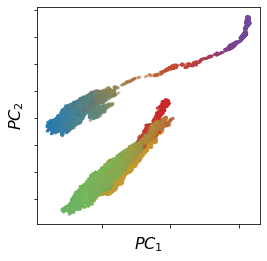

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(mean_soaps)

t_pca = pca.transform(mean_soaps)

plot_embedding(
    t_pca,
    savename='figures/Figure5/pca.png'
)

Even when our PCA is not as easily interpretable as it is here, we can use it towards data compression by looking at the variance contained in the components:

This shows that we can retain most of the variance (>99.9%) in just 35 vectors. We'll use this as our descriptor in some algorithms below for complexity's sake.


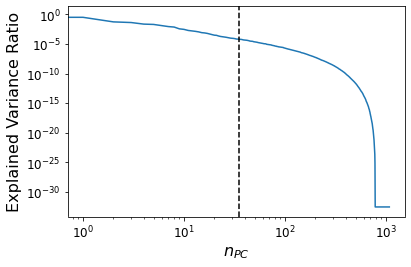

In [38]:
plt.loglog(pca.explained_variance_ratio_)
plt.gca().set_xlabel(r'$n_{PC}$')
plt.gca().set_ylabel("Explained Variance Ratio")

n_pca = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.999)[0][0]
plt.axvline(n_pca, c='k', linestyle='--')
print(
    "This shows that we can retain most of the variance (>99.9%) in just {} vectors. We'll use this as our descriptor in some algorithms below for complexity's sake."
    .format(n_pca))

plt.tight_layout()
plt.savefig('figures/Figure6.pdf')

In [10]:
pca_desc = t_pca[:, :n_pca]

In [11]:
np.savez('cyclohexane_data/pca.npz', pca=pca_desc)

### t-SNE

PCA is not intended as a clustering algorithm -- it just sometimes work out to give nice clusters.
Let's employ one of the most popular non-linear dimensionality reduction algorithm in ML field `T-distributed Stochastic Neighbor Embedding (t-SNE)` to obtain 2 dimensional representation of our descriptor space. 

Here we can see how increasing the perplexity (number of expected neighbors) changes the layout of the projection.

  0%|          | 0/6 [00:00<?, ?it/s]

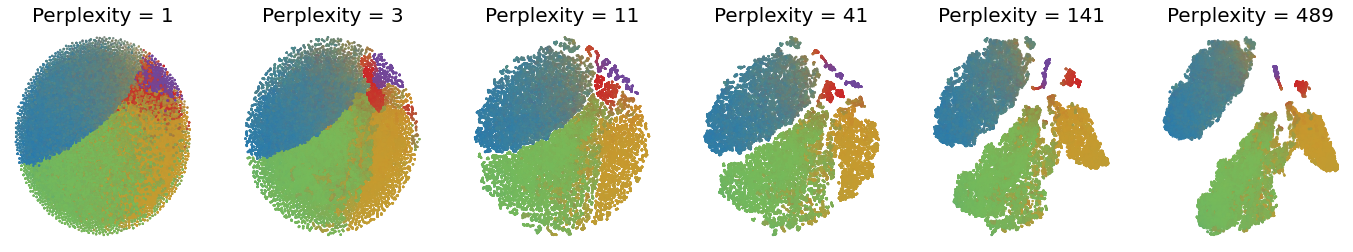

In [12]:
perplexities = np.logspace(0, 2.69, 6, dtype=int)
fig, ax = plt.subplots(1,
                       len(perplexities),
                       figsize=(4 * len(perplexities), 4),
                      )

for i, perp in enumerate(tqdm(perplexities)):
    tsne = TSNE(
        n_components=2,  # number of components to project across
        perplexity=        perp, 
        metric="euclidean",  # distance metric
        n_jobs=2,  # parallelization
        random_state=42,
        verbose=False,
    )
    t_tsne = tsne.fit(pca_desc)
    ax[i].scatter(*t_tsne.T, c=colors, s=2)
    ax[i].axis('off')
    ax[i].set_title("Perplexity = {}".format(perp))
plt.show()

In [13]:
tsne = TSNE(
    n_components=2,  # number of components to project across
    perplexity=50,  # amount of neighbors one point is posited to have... play around with this!
    metric="euclidean",  # distance metric
    n_jobs=2,  # parallelization
    random_state=42,
    verbose=False,
)
t_tsne = tsne.fit(pca_desc)

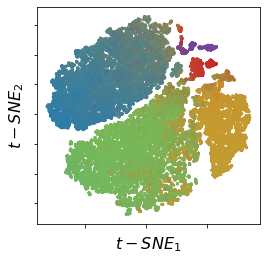

In [14]:
plot_embedding(t_tsne,
               xlabel=r'$t-SNE_1$',
               ylabel=r'$t-SNE_2$',
               savename='figures/Figure5/tsne.png'
              )

In [15]:
np.savez('cyclohexane_data/tsne.npz', t_tsne=t_tsne)

### UMAP

In [16]:
import umap

UMAP _should_ obtain similar results to t-sne, but with a shorter compute time. However, you will note a greater stochasticity to the projection when using a smaller number of neighbors -- this is due to the disconnection of the locally constructed manifolds.

  0%|          | 0/5 [00:00<?, ?it/s]

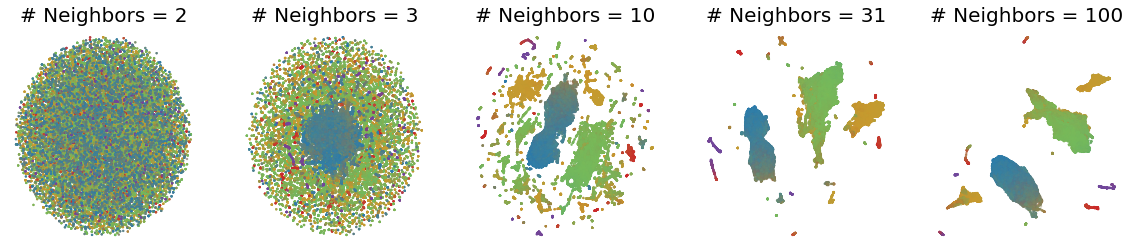

In [17]:
nneigh = np.maximum(2, np.logspace(0, 2.0, 5, dtype=int))
fig, ax = plt.subplots(1,
                       len(nneigh),
                       figsize=(4*len(nneigh), 4),
                      )

for i, n in enumerate(tqdm(nneigh)):
    um = umap.UMAP(n_components=2, n_neighbors=n, init='random')
    um.fit(pca_desc)
    t_um = um.transform(pca_desc)
    ax[i].scatter(*t_um.T, c=colors, s=2)
    ax[i].axis('off')
    ax[i].set_title("# Neighbors = {}".format(n))
plt.show()

In [18]:
um = umap.UMAP(n_components=2, n_neighbors=50)
um.fit(pca_desc)

UMAP(n_neighbors=50, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

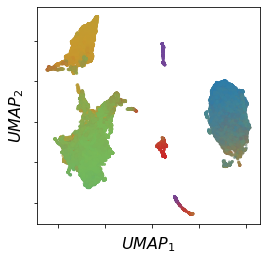

In [19]:
t_um = um.transform(pca_desc)
plot_embedding(t_um,
               xlabel=r'$UMAP_1$',
               ylabel=r'$UMAP_2$',
               savename='figures/Figure5/umap.png'
              )

In [20]:
np.savez('cyclohexane_data/umap.npz', umap=t_um)

### PCovR

PCovR is a dimensionality reduction technique that balances supervised and unsupervised learning. 
Here, we can use the parameter `mixing` to weight between unsupervised (`mixing=0`) and supervised (`mixing=1`). For more information, see the set of [PCovR / KPCovR tutorials](https://github.com/cosmo-epfl/kernel-tutorials), [(de Jong, 1992)](https://www.sciencedirect.com/science/article/pii/016974399280100I), and [(Helfrecht, 2020)](https://iopscience.iop.org/article/10.1088/2632-2153/aba9ef).

In [21]:
from skcosmo.decomposition import PCovR
from sklearn.linear_model import RidgeCV

# In PCovR, we first need to prepare a regression model
# This prevents our decomposition from overfitting on the targets
y = StandardFlexibleScaler(column_wise=True).fit_transform(np.vstack(energy))
Yp = RidgeCV(cv=2, alphas=np.logspace(-10, 2),
             fit_intercept=False).fit(pca_desc, y).predict(pca_desc)

In [23]:
pcovr = PCovR(n_components=2, mixing=0.5)
t_pcovr = pcovr.fit(pca_desc, Yp).transform(pca_desc)

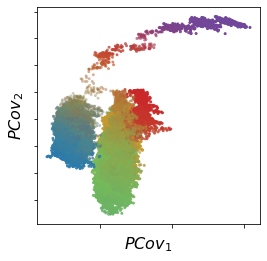

In [25]:
plot_embedding(t_pcovr,
               xlabel=r'$PCov_1$',
               ylabel=r'$PCov_2$',
               savename='figures/Figure5/pcovr.png'
              )

In [26]:
np.savez('cyclohexane_data/pcovr.npz', pcovr=t_pcovr)

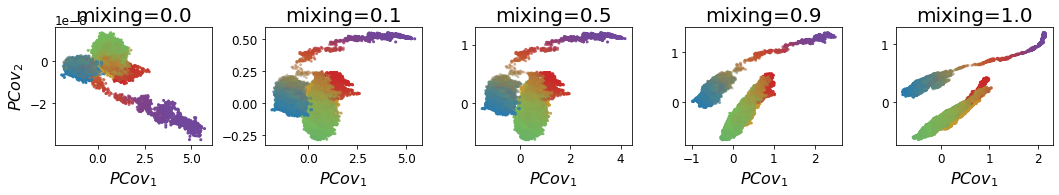

In [27]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, mixing in zip(axes, [0.0, 0.1, 0.5, 0.9, 1.0]):
    pcovr = PCovR(n_components=2, mixing=mixing)
    T = pcovr.fit(pca_desc, Yp).transform(pca_desc)

    ax.scatter(T[:, 0],
               T[:, 1],
               c=colors,
               zorder=-1,
               s=4)

    ax.set_title(f'mixing={round(mixing, 4)}')
    ax.set_xlabel(r"$PCov_1$")
    
axes[0].set_ylabel(r"$PCov_2$")
fig.tight_layout()
plt.show()

Note how at `mixing=0.0`, our second component is almost zero. This is because, working with one property, our projection is built off of a rank-1 matrix at `mixing=0.0`. 

## Non-Linear Dimensionality Reduction
### Kernel Principal Components Analysis

So far we've seen similar results from most linear methods -- a plot which shows the high-energy conformers at the ends of the projection and some middling of low-energy conformers in the center. While this demonstrates the span of structures in the simulation, our low-energy conformers are often compressed in the middle of the mapping, as they are far more similar than the high-energy oscillations. Here, we can expand the enumeration of the low-energy conformers by taking a non-linear distance of the structures.

In [28]:
from sklearn.decomposition import KernelPCA
from skcosmo.preprocessing import KernelNormalizer

When building a kernel on **averaged** representations, we construct our kernel such that

$$K(\mathcal{X}_A, \mathcal{X}_{B}) = \frac{\sum_{i \in A} \sum_{j \in B} k\left(\mathcal{X}_i, \mathcal{X}_j\right)}{N_A N_B}$$

where the kernel between structures $A$ and $B$ is the average of the kernels of each of their atomic environments. With non-linear kernels, this is not equal to the kernel of the averaged representations, i.e.

$$K(\mathcal{X}_A, \mathcal{X}_B) \neq k\left(\sum_{i\in A}\frac{\mathcal{X}_i}{N_A}, \sum_{j\in B}\frac{\mathcal{X}_j}{N_B}\right)$$


**If you want to speed up this section, which can take a while:** just un-comment the lines marked "simplify" and comment those marked "full calculation". 

In [29]:
idx = np.random.choice(range(len(traj)), 10000, replace=False) # simplify
atom_idx = np.concatenate([range(i*6, (i+1)*6) for i in idx]) # simplify

# idx = np.arange(len(traj)) # full calculation
# atom_idx = np.arange(len(soaps)) # full calculation

In [30]:
gamma = 0.1
m = 6

kernel = partial(pairwise_kernels, metric='rbf', gamma=gamma, n_jobs=6)

In [31]:
# because we know that atom-ordering is conserved in this trajectory,
# we'll only consider comparisons between identical atom indices
# this would correspond with a `best-match` kernel
K_raw = np.zeros((len(idx), len(idx)))

my_desc = np.reshape([pca.transform(split_soaps[i]) for i in idx], (len(idx) * m, -1))

for i in tqdm(range(len(idx))):
    Ki = kernel(my_desc[i * m:(i + 1) * m], my_desc[i * m:])
    for j in range(i, len(idx)):
        K_raw[i, j] = K_raw[j, i] = np.mean(
            np.diag(Ki[:, (j - i) * m:(j - i + 1) * m]))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [32]:
# we also construct a kernel between our simulation data and conformers
# in order to embed them in the same latent space
conf_K_raw = np.zeros((5, len(idx)))

for i, ci in tqdm(enumerate(conf_idx)):
    ki = kernel(pca.transform(split_soaps[ci]), my_desc)
    for j in range(len(idx)):
        conf_K_raw[i, j] = np.mean(np.diag(ki[:, j * m:(j + 1) * m]))

0it [00:00, ?it/s]

Working with centered kernels is crucial (more on this in [Helfrecht, 2020](https://iopscience.iop.org/article/10.1088/2632-2153/aba9ef)).

In [33]:
kn = KernelNormalizer(with_trace=False).fit(K_raw)
K = kn.transform(K_raw)
conf_K = kn.transform(conf_K_raw)

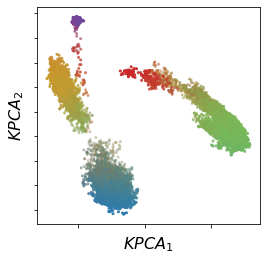

In [34]:
kpca = KernelPCA(n_components=n_pca, kernel='precomputed')
kpca.fit(K)

t_kpca = kpca.transform(K)

plot_embedding(t_kpca,
               idx=idx,
               xlabel=r'$KPCA_1$',
               ylabel=r'$KPCA_2$',
               savename='figures/Figure5/kpca.png'
              )

Here we can see a slight 'unfolding' of the trajectory, where the two different energy states are separated.

In [35]:
# properties = {"KPCA": t_kpca,
#              }
# widget = chemiscope.show([traj[i] for i in idx], properties)
# widget

### Kernel PCovR
PCovR can also be extended for non-linear distance metrics, here we can use our kernel computed in 2.2.

In [36]:
from skcosmo.decomposition import KernelPCovR
from sklearn.kernel_ridge import KernelRidge

y = StandardFlexibleScaler(column_wise=True).fit_transform(np.vstack(energy))
Yp = KernelRidge(kernel='precomputed', alpha=1E-4).fit(K, y[idx]).predict(K)
kpcovr = KernelPCovR(n_components=2, mixing=0.5)
t_kpcovr = kpcovr.fit(K, Yp).transform(K)
conf_t_kpcovr = kpcovr.transform(conf_K)

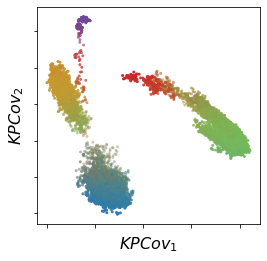

In [40]:
plot_embedding(t_kpcovr, idx=idx,
               xlabel=r'$KPCov_1$',
               ylabel=r'$KPCov_2$',
               savename='figures/Figure5/kpcovr.png'
              )

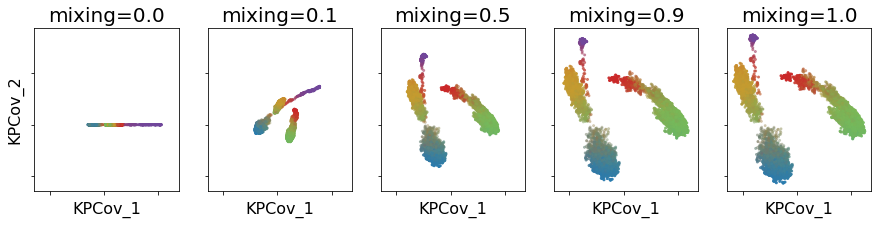

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for ax, mixing in zip(axes, [0.0, 0.1, 0.5, 0.9, 1.0]):
    kpcovr = KernelPCovR(n_components=2, mixing=mixing)
    T = kpcovr.fit(K, Yp).transform(K)

    ax.scatter(T[:, 0],
               T[:, 1],
               c=[colors[i] for i in idx],
               zorder=-1,
               s=4)

    ax.set_title(f'mixing={round(mixing, 4)}')
    ax.set_xlabel("KPCov_1")
    
axes[0].set_ylabel("KPCov_2")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])

plt.show()

## Further Exploration
Now we can export a chemiscope to play around with all of this on [chemiscope.org](chemiscope.org)!

In [43]:
import chemiscope
properties = {"PCA": t_pca[:, :5],
              "t-SNE": t_tsne,
              "UMAP": t_um,
              "PCovR": t_pcovr,
             }
widget = chemiscope.show(traj, properties)
widget.save('cyclohexanes.json')

/Users/rca/.local/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-0.07650035  0.0022456   0.78972411]' of type '<class 'numpy.ndarray'>' for the 'forces_eV_per_au' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
/Users/rca/.local/lib/python3.9/site-packages/chemiscope/adapters.py:230: UserWarning: value '[-0.07650035  0.0022456   0.78972411]' of type '<class 'numpy.ndarray'>' for the 'forces' property from ASE is not convertible to float or string, this property will be ignored.
  warnings.warn(
